# 3 

In [1]:
import pandas as pd 
%pylab inline 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data should be downloaded from here 
https://drive.google.com/file/d/1-mu1J2wnlDIVNzoCXw20jJQ9r-h1jGrZ/view?usp=sharing

In [2]:
# # figuring out the encoding
# !pip install chardet
# import chardet

# with open("AMI_GSE66360_series_matrix.csv",'rb') as f:
#     # Join binary lines for specified number of lines
#     rawdata = b''.join([f.readline() for _ in range(500)])

# chardet.detect(rawdata)['encoding']

# result is: ISO-8859-1


In [3]:
## I think we dont need this part

# # reading the stuff from the file that looks like a table 26-57 (the metadata)

# df_meta=pd.read_csv(
#     "AMI_GSE66360_series_matrix.csv",
#     encoding='ISO-8859-1',
#     engine='python',
#     sep="\"\"\",*.*|\"\!Sample_|\"\"\t\"\"|\t\"\"",
#     skiprows=25,nrows=57-26
# )

# df_meta = df_meta.drop(columns=["Unnamed: 0","Unnamed: 101"])

# df_meta = df_meta.set_index("title")
# df_meta = df_meta.T
# df_meta = df_meta.reset_index()
# df_meta = df_meta.rename(columns={"index":"name"})

In [4]:
# This first table has no relevant information, reading the other one 
df=pd.read_csv(
    "HW4\AMI_GSE66360_series_matrix.csv",
    encoding='ISO-8859-1',
    skiprows=59,
    header=[0,1],
)

df = df.set_index(("Class","ID_REF"))

In [5]:
# the columns are some 99 patients tagged as healthy or sick. The rows are checks/features 
# all fields are numerical (55k features??)
df.shape 

(54675, 99)

In [6]:
# description of some random feature (1405_i_at)
df.T.iloc[:,8].describe()

count    99.000000
mean      9.896761
std       1.392008
min       5.375997
25%       9.462845
50%      10.190275
75%      10.883331
max      11.985246
Name: 1405_i_at, dtype: float64

# Answering the questions

## a. High level description of the data and some pre-processing
1) How many genes profiled?
2) How many samples (subjects/patients) in total?
3) How many samples in each class?
4) If there are missing values, then remove the entire row(gene) from the data matrix. How many rows left now?
5) Pick 20 genes at random. Draw 20 pair boxplots in one figure comparing expression levels of each of these genes in the two classes M and H.

1 - total of 54675 profiled genes

2 - total of 99 samples

3 - Healthy - 50, Myocardial infarction - 49

4 - 54628 (47 genes with nan values)

In [7]:
df.T.index.get_level_values(0).value_counts()

H    50
M    49
dtype: int64

In [8]:
# removing rows with nans
df = df.loc[~df.T.isna().any()]
df.shape

(54628, 99)

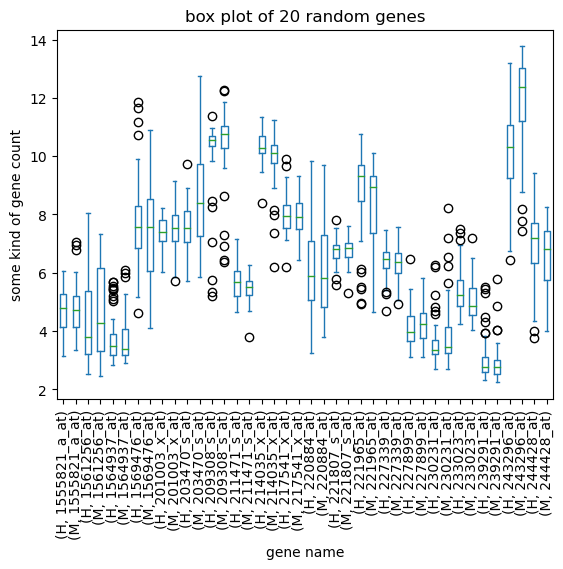

In [9]:
df_20_random_pick = df.sample(20).T # picking 20 randomly
df_20_random_pick = df_20_random_pick.stack().unstack(level=[0,2]) # seperating the classes
df_20_random_pick = df_20_random_pick.reindex( # sorting by gene first
    columns=sorted(df_20_random_pick,key=lambda x:x[1])
)
df_20_random_pick.plot(kind="box",rot=90) # plotting the box plots in the same figure
plt.title("box plot of 20 random genes")
plt.xlabel("gene name")
plt.ylabel("some kind of gene count");

## b. WRS for differential expression (DE)
1) Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?
2) Denote this sum of ranks by RS(g). What is the maximal value, c, that RS(g) can take?
3) Under the null model, what is the probability of RS(g) = c? (Provide a formula for this and explain it)
4) Under the null model, what is the probability of RS(g) = c-1? what is the probability of RS(g) = c-2? (Provide formulas and explain them)
5) Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up). Compute the IQR for this distribution and present it on the plot with the histogram.

### 1 
if the M/H ranks are distributed randomly then we can assume the expectation will be approximately $\mu_T=B(N+1)/2=49*51/2=1249.5$ 
### 2 
c = nM*nH = 49*50 = 2450 (for the case where all the M samples have higher rank than all the H samples). A nother way to calculate is: maximum for sum of M ranks - nM(nM+1)/2 = (nH+1+nH+nM)nM/2 - nM(nM+1)/2 = nH*nM
### 3 
We have a single ranking where RS(g)=c out of (nM+nH over nM) equally possible rankings, leading to P(RS(g)=c)=1/(nM+nH over nM)=1/(99 over 49). Here "(x over y)" is the binomial coefficient. 
### 4 
P(RS(g)=c-1) = 1/(99 over 49) = 0. Because we still have only one configuration of rankings resulting in this specific RS(g). P(RS(g)=c-2) = 2/(99 over 49). There are two ways to achieve the rights rankings - either by lowering the rank of the lowest M sample twice or rising the rank of the highest H sample twice. 
### 5


In [10]:
from scipy.stats import mannwhitneyu
from tqdm import tqdm 
tqdm.pandas(desc="u test on all genes")
u_M_test = df.T.stack().unstack(level=[0]).groupby(level=1).progress_apply(
    lambda x:mannwhitneyu(x.M,x.H,nan_policy='omit')[0]
)

u test on all genes: 100%|█████████████████████████████████████████████████████| 54628/54628 [00:39<00:00, 1369.10it/s]


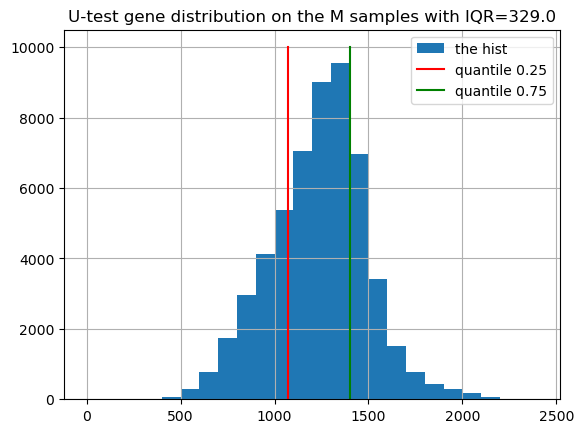

In [11]:
# computing IQR
u_M_q25 =  u_M_test.quantile(0.25)
u_M_q75 =  u_M_test.quantile(0.75)
u_M_IQR = u_M_q75 - u_M_q25

# plotting
u_M_test.hist(bins=range(0,2500,100),label="the hist")
plt.plot([u_M_q25]*2,[0,10000],'r-',label="quantile 0.25")
plt.plot([u_M_q75]*2,[0,10000],'g-',label="quantile 0.75")
plt.title(f"U-test gene distribution on the M samples with IQR={u_M_IQR}")
plt.legend()

## c. Differential Expression

The purpose is to determine the statistical significance of
differential expression (DE) observed for each gene in H vs M.
Evaluate the DE in both one-sided directions for every gene,
using both Student t-test and WRS test.
Report the number of genes overexpressed in M vs H (M > H) at
a p-value better (≤) than 0.07 and separately genes
underexpressed in M vs H (M < H) at a p-value better than 0.07.
For both directions use both a Student t-test and a WRS test.

In [12]:
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm 


In [13]:
df_for_tests = df.T.stack().unstack(level=[0])

In [14]:
df_for_tests.head() 
# here first index is patient, second index is gene, one of the H and M columns is always nan

H   M
           (Class, ID_REF)              
GSM1620819 1007_s_at        5.866378 NaN
           1053_at          8.225790 NaN
           117_at           6.179732 NaN
           121_at           6.179478 NaN
           1255_g_at        2.792048 NaN

In [15]:
df_for_tests.shape

(5408172, 2)

In [16]:
test_kwargs = dict(nan_policy='omit',alternative='greater')
tqdm.pandas(desc="statistical significance on all genes on both sides both t-test and WRS-test")
U_M_greater_test = df_for_tests.groupby(level=1).progress_apply(
    lambda x:mannwhitneyu(x.M,x.H,**test_kwargs)[1]
)
U_H_greater_test = df_for_tests.groupby(level=1).progress_apply(
    lambda x:mannwhitneyu(x.H,x.M,**test_kwargs)[1]
)
T_M_greater_test = df_for_tests.groupby(level=1).progress_apply(
    lambda x:ttest_ind(x.M,x.H,**test_kwargs)[1]
)
T_H_greater_test = df_for_tests.groupby(level=1).progress_apply(
    lambda x:ttest_ind(x.H,x.M,**test_kwargs)[1]
)

statistical significance on all genes on both sides both t-test and WRS-test: 100%|█| 54628/54628 [00:38<00:00, 1404.15
statistical significance on all genes on both sides both t-test and WRS-test: 100%|█| 54628/54628 [00:38<00:00, 1408.11
statistical significance on all genes on both sides both t-test and WRS-test: 100%|█| 54628/54628 [00:39<00:00, 1388.77
statistical significance on all genes on both sides both t-test and WRS-test: 100%|█| 54628/54628 [00:38<00:00, 1420.64


In [17]:
# utest overexpressed in M
U_M_greater_test[U_M_greater_test <= 0.07].index

Index(['117_at', '1320_at', '1552271_at', '1552276_a_at', '1552279_a_at',
       '1552288_at', '1552289_a_at', '1552293_at', '1552329_at', '1552335_at',
       ...
       'AFFX-M27830_M_at', 'AFFX-PheX-3_at', 'AFFX-ThrX-3_at',
       'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at',
       'AFFX-TrpnX-M_at', 'AFFX-r2-Bs-phe-3_at', 'AFFX-r2-Bs-phe-5_at',
       'AFFX-r2-Bs-thr-5_s_at'],
      dtype='object', name=('Class', 'ID_REF'), length=10721)

In [18]:
# ttest overexpressed in M
T_M_greater_test[T_M_greater_test <= 0.07].index

Index(['117_at', '1320_at', '1552276_a_at', '1552289_a_at', '1552293_at',
       '1552329_at', '1552335_at', '1552337_s_at', '1552349_a_at',
       '1552355_s_at',
       ...
       '89948_at', '90265_at', '91682_at', '91684_g_at', 'AFFX-LysX-3_at',
       'AFFX-M27830_5_at', 'AFFX-M27830_M_at', 'AFFX-PheX-3_at',
       'AFFX-ThrX-3_at', 'AFFX-r2-Bs-phe-3_at'],
      dtype='object', name=('Class', 'ID_REF'), length=8517)

In [19]:
# utest overexpressed in H
U_H_greater_test[U_H_greater_test <= 0.07].index

Index(['1294_at', '1316_at', '1405_i_at', '1431_at', '1552277_a_at',
       '1552280_at', '1552283_s_at', '1552286_at', '1552299_at', '1552302_at',
       ...
       '64432_at', '64883_at', '65438_at', '65472_at', '65585_at', '78383_at',
       '81811_at', '91617_at', 'AFFX-HUMISGF3A/M97935_3_at',
       'AFFX-HUMISGF3A/M97935_MB_at'],
      dtype='object', name=('Class', 'ID_REF'), length=10618)

In [20]:
# ttest overexpressed in H
T_H_greater_test[T_H_greater_test <= 0.07].index

Index(['1316_at', '1405_i_at', '1431_at', '1552277_a_at', '1552280_at',
       '1552283_s_at', '1552286_at', '1552299_at', '1552310_at',
       '1552312_a_at',
       ...
       '64064_at', '64408_s_at', '64418_at', '64883_at', '65438_at',
       '65472_at', '65585_at', '81811_at', '91617_at',
       'AFFX-HUMISGF3A/M97935_3_at'],
      dtype='object', name=('Class', 'ID_REF'), length=8639)

## d. Correlations
Select the 80 most significant genes from each one of the one-
sided WRS DE lists you computed in 3c. Generate a set of 160
genes, D, which is the union of the above two sets.
1) Compute Kendall 𝜏 correlations in all pairs within D (160 choose 2 numbers). Represent the correlation matrix as a 160x160 heatmap.
2) Under a NULL model that assumes that genes are pairwise independent, what is the expected value for 𝜏?
3) Now compute the Kendall 𝜏 correlations in all 80 choose 2 pairs from the overexpressed genes in D. Present your results on a histogram. What is the average value you observed? Compare it to the value in the above section. Explain.
4) What can you report about co-expression of genes in D (co-expression is inferred from the correlation of the expression levels of genes, across a set of samples)?
5) What can you say about how many co-expressed pairs we would observe (in the entire dataset) at FDR=0.05? Explain your answer.
6) What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D?

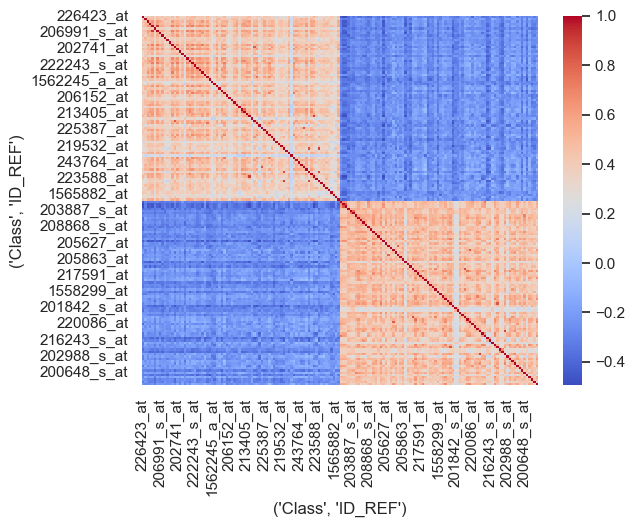

In [511]:
import seaborn as sns

# construct D = 160 Genes with most significant genes from WRS test
D_ind = pd.concat([U_H_greater_test.nsmallest(n=80), U_M_greater_test.nsmallest(n=80)]).index
D = df.loc[D_ind].T
D_kendall = D.corr(method='kendall')
sns.set(style="whitegrid")
sns.heatmap(D_kendall, cmap='coolwarm');

2. If the genes are pairwise independent their rankings are not related, and we expect the correlation between their rankings to be zero, so $\tau = 0$.

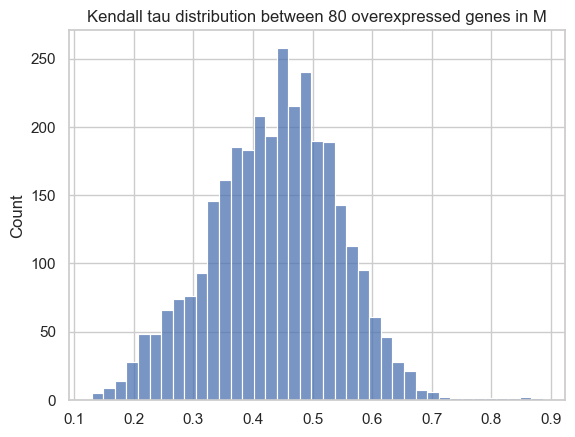

In [484]:
#Kendall for 80 most significant genes that are overexpressed in M
U_M_greater_ind = U_M_greater_test.nsmallest(n=80).index
D_kendall_M_greater = D_kendall.loc[U_M_greater_ind][U_M_greater_ind].to_numpy(dtype='float')

#take the upper triangle of values and flatten
D_kendall_M_greater = D_kendall_M_greater[np.triu_indices(80, k = 1)].flatten()
sns.histplot(D_kendall_M_greater);
plt.title("Kendall tau distribution between 80 overexpressed genes in M");

In [23]:
mean(D_kendall_M_greater)

0.43633375511448963

3. The mean value of $\tau = 0.43$, therefore the genes sampled from those overexpressed in the M population are not pairwise independent, meaning they are conditionally dependant. This is also evicended by the heatmap of the correlation matrix (next question). If they were independant, we would expect $\tau = 0$ on average.



4. From the above correlation matrix we can say that the correlation matrix is divided into 4 quadrants. They stem from the fact that we have two types of genes in this comparison: Those who are overabundant in H vs. M and vice versa. So each quadrant represents the correlation between those in H vs. H, H vs. M and vice versa.

    From the matrix we can say that those pairs from the same group tend to have a higher correlation value.
    
<font color='red'>In the entire dataset we have n choose 2 pairs = 1,492,081,878 pairs. Using a p-value of 0.05, under the null model, we expect $Np = 74,604,093$ pairs to have $p_{value} < 0.05$. Using the formula for $FDR = \frac{pN}{O(p)}$ and plugging $FDR = 0.05$ we can estimate $O(p) = \frac{pN}{FDR} = $</font>

6. Advantages:
- Could  detect correlations between all the genes in the dataset, and not just a subset.
 
- We could detect co-expression patterns in the entire dataset.

Distadvantages: 
- It makes intuitive sense that genes that are over or under expressive in population M or H would be also co-correlated. Therefore by looking into this subset of genes there is a higher chance of finding correlating pairs.

- More computationally intensive, more difficult to visuallize and draw conclusions.

## e. Plots and Conclusions of the DE and correlation analysis
1) Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c. State, for each comparison, the number of genes, k, at which we observe with an FDR threshold of:
a) 𝜏 = 0.05
b) 𝜏 = 0.01
c) 𝜏 = 0.005
If these events are not observed at any k>0, then make that
statement.
2) For any given gene, g, consider the following set of p-values: 𝑝(𝜆) 𝑖𝑠 𝑎 𝑊𝑅𝑆 𝑝 − 𝑣𝑎𝑙𝑢𝑒 𝑆(𝑔) = {𝑝(𝜆)| 𝑓𝑜𝑟 𝑜𝑣𝑒𝑟𝑒𝑥𝑝𝑟𝑒𝑠𝑠𝑖𝑜𝑛 𝑖𝑛 𝑀 } 𝑎𝑓𝑡𝑒𝑟 𝑠𝑤𝑎𝑝𝑝𝑖𝑛𝑔 𝑜𝑛𝑒 𝑙𝑎𝑏𝑒𝑙 (In the above definition 𝜆 represents a label swap – there are 99 such swaps). Let 𝑝𝑈 (𝑔) = max 𝑆(𝑔) 𝜆 In words: 𝑝𝑈 (𝑔) represents the maximum p-value that could have been obtained for g, assuming a single labeling error.
a) For all genes, compute 𝑝𝑈 (𝑔).
b) Run the FDR procedure with 𝜏 = 0.05 using 𝑝𝑈 (𝑔)
(instead of the original p-values as computed in
section 3e1a above). How many genes can you report
now?
c) What is the intersection of the genes you can report
above with the results of 3e1a. Explain.
Comment: The process you ran in this section yields a set
of genes called Robust Differentially Expressed Genes
(RDEG).
IDC
4/33) Select any 3 differentially expressed genes, from D (which
was defined in 3d), and produce a graphical representation of
their expression patterns that demonstrates the observed DE.
4) Heatmap
Draw a heatmap representation of the expression values of
the genes in D (from 3d), across the entire cohort (all
samples). Order the genes and the samples to produce the
maximal visual effect.

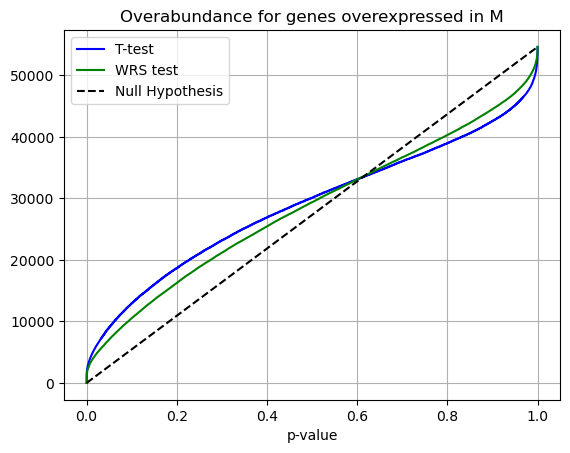

In [171]:
#calculate the FDR q-value for wrs
WRS_k = len(U_M_greater_test)
t_k = len(T_M_greater_test)

#plot overabundance plot
plt.plot(U_M_greater_test.sort_values(), np.arange(1, WRS_k+1), color = 'b')
plt.plot(T_M_greater_test.sort_values(), np.arange(1, t_k+1), color = 'g')
plt.plot([0, 1], [0, WRS_k], 'k--')
plt.xlabel('p-value');
plt.title('Overabundance for genes overexpressed in M');
plt.legend(['T-test', 'WRS test', 'Null Hypothesis']);
plt.grid()

In [162]:
#compute q-value
WRS_qval = (U_M_greater_test.sort_values() * WRS_k) / np.arange(1, WRS_k+1)
t_qval = (T_M_greater_test.sort_values() * t_k) / np.arange(1, t_k+1)

#print number of events pass threshold
print('Using WRS, the number of events where tau < 0.05: ',np.sum(WRS_qval <= 0.05), ', tau < 0.01:', np.sum(WRS_qval <= 0.01), ', and tau < 0.005: ',  np.sum(WRS_qval <= 0.005))
print('Using T-test, the number of events where tau < 0.05: ',np.sum(t_qval <= 0.05), ', tau < 0.01:', np.sum(t_qval <= 0.01), ', and tau < 0.005: ',  np.sum(t_qval <= 0.005))

Using WRS, the number of events where tau < 0.05:  2784 , tau < 0.01: 1601 , and tau < 0.005:  1315
Using T-test, the number of events where tau < 0.05:  2104 , tau < 0.01: 1305 , and tau < 0.005:  1104


1. These are the number of genes (event) we can resport at each $\tau$ level (see result above).
2. a. We will compute $p_u(g)$ for overexpression in M:

In [368]:
import joblib

def d_func(d_name,d):
    d_res = max([mannwhitneyu(
        np.r_[d.M.values[:i],d.H.values[i:i+1],d.M.values[i+1:]],
        np.r_[d.H.values[:i],d.M.values[i:i+1],d.H.values[i+1:]],
        **test_kwargs
    )[1] for i in range(len(d))])
    return d_name,d_res

U_M_greater_test_robust = joblib.Parallel(n_jobs=16)(
    joblib.delayed(d_func)(*dd) for dd in tqdm(df_for_tests.groupby(level=1))
)

100%|████████████████████████████████████████████████████████████████████████████| 54628/54628 [12:44<00:00, 71.50it/s]


In [393]:
#Cache to disk
gene , pu_g = zip(*U_M_greater_test_robust)
np.savetxt("HW4\e2_pu_data.csv", np.stack([gene,statistic,pval], axis = 1), fmt="%s", delimiter=",", header="Gene, Statistic, pu_g")

In [394]:
#Compute FDR q-values
pu_g = pd.Series(data = pu_g, index = gene)
pu_g_qval = (pu_g.sort_values() * WRS_k) / np.arange(1, WRS_k+1)
print('Using pu(g), the number of events where tau < 0.05: ',np.sum(pu_g_qval <= 0.05), ', tau < 0.01:', np.sum(pu_g_qval <= 0.01), ', and tau < 0.005: ',  np.sum(pu_g_qval <= 0.005))

Using pu(g), the number of events where tau < 0.05:  1842 , tau < 0.01: 1108 , and tau < 0.005:  938


2. b. Compared with e.1, we have less events which we can report at each $\tau$ level. This is expected since we increased the p-values and selected only those which passed the robustness test. 

In [405]:
#(pu_g_qval[pu_g_qval <= 0.05]).index
pu_wrs_diff_idx = (pu_g_qval[pu_g_qval <= 0.05]).index.isin(WRS_qval[WRS_qval <= 0.05].index)
print('The number of genes that appear in the p_u(g) report and do not appear in the WRS report is: ', np.size(pu_wrs_diff_idx) - np.count_nonzero(pu_wrs_diff_idx))

The number of genes that appear in the p_u(g) report and do not appear in the WRS report is:  0


c. The intersection between genes reported with $FDR = 0.05$ using $p_u(g)$ and WRS is equal to the group of genes reported using $p_u(g)$. This is evident by the calculation above.

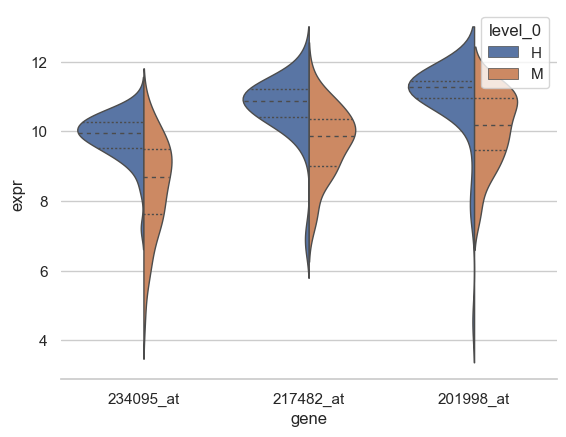

In [487]:
D_select_3 = D.iloc[:,[1,10,20]]

D_select_3 = (D.iloc[:,[1,10,20]].reset_index())
D_select_3 = D_select_3.melt(id_vars=['level_1','level_0'],value_vars=['234095_at', '217482_at','201998_at'])
D_select_3.columns = ['level_1', 'level_0', 'gene', 'expr']

sns.set(style="whitegrid")
sns.violinplot(data=D_select_3, y = 'expr', x = 'gene', hue = 'level_0', split=True, inner="quart", linewidth=1);
sns.despine(left=True)

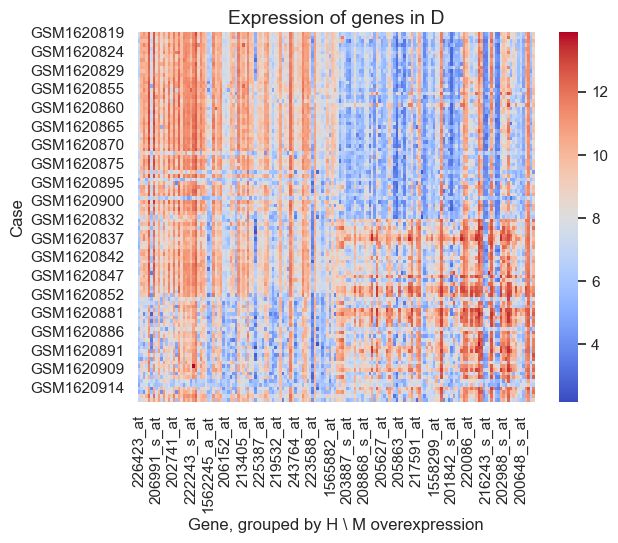

In [547]:
D_grouped = D.sort_index(level = 0)
D_grouped =  D_grouped.droplevel(level = 0)
sns.heatmap(data = D_grouped, cmap='coolwarm');
plt.title("Expression of genes in D", fontsize = 14);
plt.xlabel('Gene, grouped by H \ M overexpression');
plt.ylabel('Case');